# EIM for MSFR: external sensors

The sensors are placed externally using the Empirical Interpolation Method

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pickle

var_names, is_vector, times = pickle.load(open('msfr_uloff.set', 'rb'))

path_svd = './OfflineSVD/'
var_names = pickle.load(open(path_svd+"var.names", 'rb'))
rescaling_snaps = pickle.load(open(path_svd+"rescaling.svd", 'rb'))

Let us import the mesh

In [2]:
from mesh import *
from dolfinx.fem import Function, FunctionSpace, locate_dofs_topological
import ufl
from IPython.display import clear_output

domain, ct, ft = evol_mesh()

fun_spaces = [FunctionSpace(domain, ('Lagrange', 1))]*(len(var_names)-1)
fun_spaces.append(FunctionSpace(domain, ufl.VectorElement("CG", domain.ufl_cell(), 1)))

measured_field = 0

clear_output()
print('The observable field is '+var_names[measured_field])

reflector_mark = 20
refl_tags = locate_dofs_topological(fun_spaces[measured_field], ct.dim, ct.find(reflector_mark))
Nh = fun_spaces[measured_field].tabulate_dof_coordinates().shape[0]

The observable field is flux1


Let us import the snapshots

In [3]:
from pyforce.tools.write_read import ImportH5
from pyforce.tools.functions_list import FunctionsList, train_test_split

compressed_data = True

if compressed_data:
    path_snaps = './CompressedDataset/'
    
    compressed_u_total = pickle.load(open(path_snaps+"u_total.svd", 'rb'))
    compressed_v_total = pickle.load(open(path_snaps+"v_total.svd", 'rb'))
    compressed_s_total = pickle.load(open(path_snaps+"s_total.svd", 'rb'))
    compressed_rescaling_snaps = pickle.load(open(path_snaps+"rescaling.svd", 'rb'))
    compressed_Nmodes = pickle.load(open(path_snaps+"Nmodes.svd", 'rb'))
    
    field = var_names[measured_field]

    snaps = FunctionsList(fun_spaces[measured_field])

    v = compressed_v_total[int(np.sum(compressed_Nmodes[:measured_field])) : int(np.sum(compressed_Nmodes[:measured_field+1]))]
    rec = rescaling_snaps[measured_field] * (compressed_u_total[field] @ (np.diag(compressed_s_total[field]) @ v))
    for tt in range(v.shape[1]):
        snaps.append(rec[:,tt])
else:
    path_snaps = './dolfinx_data/'
    snaps, _ = ImportH5(fun_spaces[measured_field], path_snaps+var_names[measured_field], var_names[measured_field], verbose=False)

train_snaps = FunctionsList(fun_spaces[measured_field])
test_snaps  = FunctionsList(fun_spaces[measured_field])

train_time = list()
test_time  = list()

for ii in range(len(snaps)):
    if (ii+1) % 2:
        train_snaps.append(snaps(ii) / rescaling_snaps[measured_field])
        train_time.append(times[ii])
    else:
        test_snaps.append(snaps(ii) / rescaling_snaps[measured_field])
        test_time.append(times[ii])
        
assert len(train_snaps) + len(test_snaps) == len(snaps)
assert len(train_time) + len(test_time) == len(times)
assert len(train_snaps) == len(train_time)
assert len(test_snaps) == len(test_time)

## Offline Phase
The EIM is used to generate a reduced space and to find the optimal positions for sensors

In [4]:
from eim import EIM

eim_class = EIM(domain.geometry.x, var_names[measured_field])

Mmax = 15
_xm = [tag for tag in refl_tags]
max_abs_err, max_rel_err, _ = eim_class.offline(train_snaps, Mmax, _xm, verbose=True)

Let us plot the locations of sensors

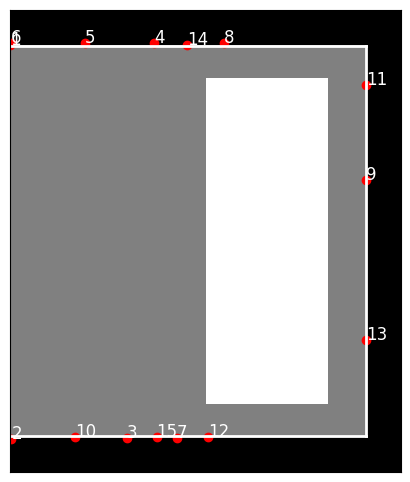

In [5]:
import matplotlib.patches as patches

# Assuming necessary imports and data are available
cmap = plt.cm.jet_r
fig, axs = plt.subplots(figsize=(6, 6))

mesh = fun_spaces[measured_field].tabulate_dof_coordinates()

# Defining the rectangles for the blue zones
rect_core = patches.Rectangle((0, -2.26/2), 2.05, 2.26, linewidth=1, facecolor='gray')
rect_reflector_top = patches.Rectangle((0, 2.26/2), 2.25, 0.20, linewidth=1, facecolor='black')
rect_reflector_bot = patches.Rectangle((0, -2.26/2), 2.25, -0.20, linewidth=1, facecolor='black')
rect_reflector_lateral = patches.Rectangle((2.05, -2.26/2), 0.2, 2.26, linewidth=1, facecolor='black')
rect_blanket = patches.Rectangle((1.13, -1.88/2), 0.7, 1.88, linewidth=1, facecolor='white')

axs.add_patch(rect_core)
axs.add_patch(rect_reflector_top)
axs.add_patch(rect_reflector_bot)
axs.add_patch(rect_reflector_lateral)
axs.add_patch(rect_blanket)

# Setting the limits and aspect
axs.set_xlim(0, 2.25)
axs.set_ylim(-2.66/2, 2.66/2)
axs.set_aspect('equal')

# Scatter plot for sensor locations
mag_pts = np.asarray(eim_class.magic_points['points'])
axs.scatter(mag_pts[:,0], mag_pts[:,1], color='r')
for i in range(mag_pts.shape[0]):
    axs.text(mag_pts[i, 0], mag_pts[i, 1], str(i+1), c='white', fontsize=12, ha='left')

axs.set_xticks([])
axs.set_yticks([])

# Plot lines
axs.plot([-0.25, 2.05], [2.25/2]*2, c='white', linewidth=2)
axs.plot([-0.25, 2.05], [-2.25/2]*2, c='white', linewidth=2)
axs.plot([2.05]*2, [2.25/2, -2.25/2], c='white', linewidth=2)

Let us create some measurements from the training data

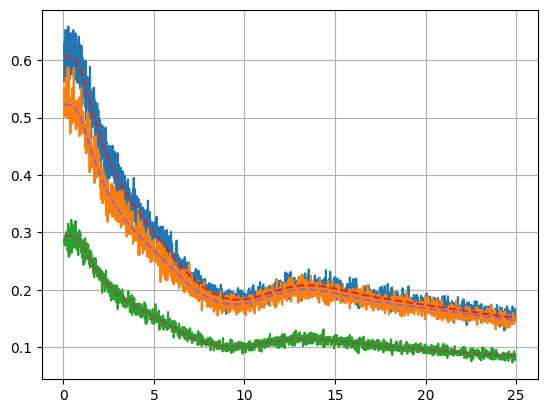

In [6]:
from scipy.interpolate import CubicSpline

num_sensors = 3
noise_value = 5/100
snap_measurements = np.zeros((num_sensors, len(train_snaps), 1))

for tt in range(len(train_snaps)):
    snap_measurements[:, tt, 0] = train_snaps(tt)[eim_class.magic_points['idx'][:num_sensors]]
    
t = train_time
newnt = 2000
new_t = np.linspace(t[0], t[-1], newnt)

noise_value = 5/100
Xsensor = np.zeros((num_sensors, newnt, 1))

for j in range(num_sensors):
    
    measure = snap_measurements[j, :, 0]
    
    spline = CubicSpline(t, measure)
    Xsensor[j, :, 0] = spline(new_t) * (1 + np.random.normal(scale=noise_value, size=new_t.shape))
    
    
plt.plot(new_t, Xsensor[:,:,0].T, label='Spline')
plt.plot(train_time, snap_measurements[:,:,0].T, '--', label='FOM')
plt.grid()

Let us store the data

In [7]:
measurements = dict()
measurements['mesh'] = mesh
measurements['location'] = np.array(eim_class.magic_points['idx'][:num_sensors]).reshape(-1,1)
measurements['point_spread'] = 0
measurements['noise'] = noise_value

measurements['measured_field'] = measured_field

measurements['noisy_output'] = Xsensor

pickle.dump(measurements, open(path_svd+'measurements_EIM.data', 'wb'))

## Online Phase
Let us test the reconstruction of the EIM algorithm for unseen data

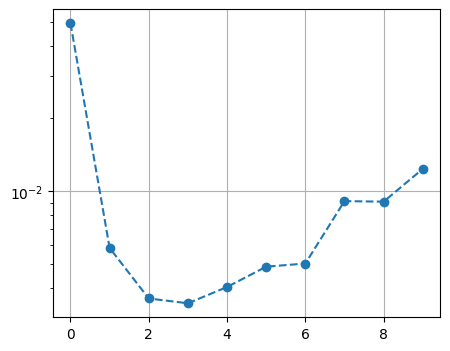

In [8]:
Mmax_test = 10

noise_value = 1e-4
ave_test_abs_err, ave_test_rel_err, _ = eim_class.test_error(test_snaps, Mmax=Mmax_test, noise_value = noise_value)

fig = plt.figure(figsize=(5,4))
plt.semilogy(ave_test_rel_err, 'o--')
plt.grid()

pickle.dump([ave_test_abs_err, ave_test_rel_err], open(path_svd+'test_errors.eim', 'wb'))

Let us make a contour plot

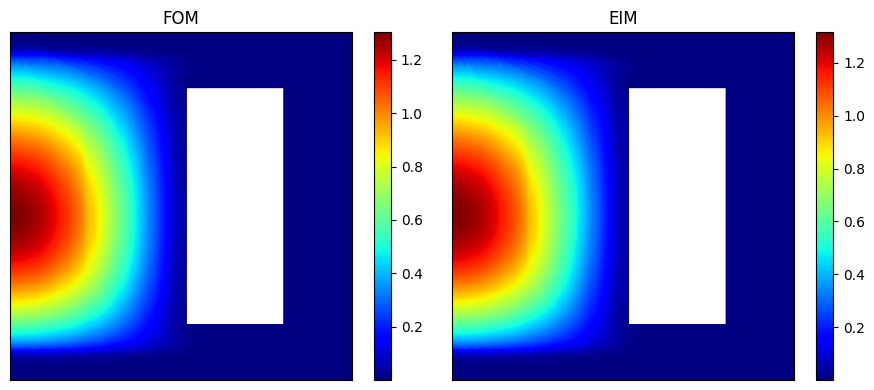

In [9]:
idx = 100

rec = eim_class.magic_fun.return_matrix()[:, :Mmax_test] @ eim_class.reconstruct(test_snaps(idx), Mmax=Mmax_test, noise_value = noise_value)[0]

fig, axs = plt.subplots(ncols = 2, figsize=(9,4))
fom_ = axs[0].scatter(domain.geometry.x[:,0], domain.geometry.x[:,1], c=test_snaps(idx), cmap=cm.jet)
axs[0].set_title('FOM')
plt.colorbar(fom_)

eim_ = axs[1].scatter(domain.geometry.x[:,0], domain.geometry.x[:,1], c=rec, cmap=cm.jet)
axs[1].set_title('EIM')
plt.colorbar(eim_)

for ax in axs:
    ax.set_xlim(min(domain.geometry.x[:,0]), max(domain.geometry.x[:,0]))
    ax.set_ylim(min(domain.geometry.x[:,1]), max(domain.geometry.x[:,1]))
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()